# Librerías

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
import time
import platform
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from gcn_model import GCN
from torch_geometric.loader import DataLoader
from dataset_utils import generate_edge_index, build_graph_list, build_graph_from_sample
from train_eval import train, evaluate, EarlyStopping

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Propiedades del sistema
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda
    print("system_specs", system_specs)


system_specs {'os': 'Windows', 'os_version': '10.0.22000', 'machine': 'AMD64', 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel', 'python_version': '3.12.9', 'device': 'cuda', 'gpu_name': 'NVIDIA GeForce RTX 2060', 'gpu_memory_total_GB': 6.0, 'cuda_version': '12.1'}


In [4]:
dir_path = os.getcwd()
print(dir_path)

c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina\GCN_MK1


In [5]:
# Ruta del dataset completo
dataset_path = os.path.join(dir_path, "Datasets", "PCB_dataset.pth")
norm_dataset_path = os.path.join(dir_path, "Datasets", "PCB_Dataset_Norm.pth")
info_path = os.path.join(dir_path, "Datasets", "normalization_info.pth")

# Cargar dataset
dataset = torch.load(dataset_path)
norm_dataset = torch.load(norm_dataset_path)
norm_info = torch.load(info_path)

C:\Users\ramse\AppData\Local\Temp\ipykernel_3308\1864307277.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
C:\Users\ramse\AppData\Loc

## Para desnormalizar

In [6]:
max_T_interfaces = norm_info["max_T_interfaces"]
max_Q_heaters = norm_info["max_Q_heaters"]
max_T_env = norm_info["max_T_env"]
max_T_outputs = norm_info["max_T_outputs"]
print("max_T_output", max_T_outputs)

def desnormalize_inputs(dataset_norm, idx):
    T_interfaces_norm = dataset_norm.T_interfaces[idx]
    Q_heaters_norm = dataset_norm.Q_heaters[idx]
    T_env_norm = dataset_norm.T_env[idx]
    
    T_interfaces_real = T_interfaces_norm * max_T_interfaces
    Q_heaters_real = Q_heaters_norm * max_Q_heaters
    T_env_real = T_env_norm * max_T_env
    
    return T_interfaces_real, Q_heaters_real, T_env_real

max_T_output tensor(364.9723)


In [7]:
idx = 1
T_interfaces_real, Q_heaters_real, T_env_real = desnormalize_inputs(norm_dataset, idx)

# Por ejemplo:
print(torch.max(T_interfaces_real), "K")
print(torch.max(Q_heaters_real), "W")
print(torch.max(T_env_real), "K")


tensor(307.6863) K
tensor(0.8122) W
tensor(276.9086) K


In [8]:
# Seleccionar un índice para graficar
idx = 1  # Puedes cambiar este valor

# Obtener los valores reales de las CC en T, Q y T_env
T_interfaces_real = dataset.denormalize_T_interfaces(dataset.T_interfaces)
Q_heaters_real = dataset.denormalize_Q_heaters(dataset.Q_heaters)
T_env_real = dataset.denormalize_T_env(dataset.T_env)

print(T_interfaces_real.shape)
print(torch.max(T_interfaces_real[idx]), "K")
print(torch.max(Q_heaters_real[idx]), "W")
print(torch.max(T_env_real[idx]), "K")


torch.Size([30000, 13, 13])
tensor(307.6863) K
tensor(0.8122) W
tensor(276.9086) K


In [9]:
idx = 10
T_interfaces_norm = norm_dataset.T_interfaces[idx]
Q_heaters_norm = norm_dataset.Q_heaters[idx]
T_env_norm = norm_dataset.T_env[idx]

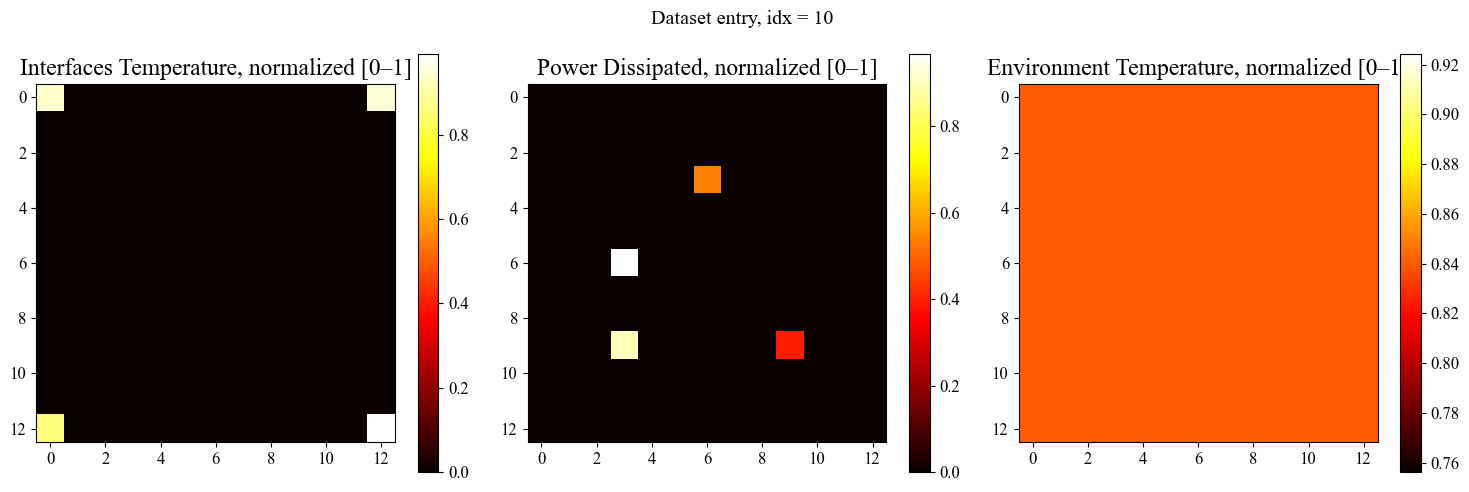

In [10]:
# === Configuración de estilo global ===
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)   # Figura por defecto
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["text.usetex"] = False
plt.rcParams["axes.titlesize"] = 17

# === Crear figura específica para mostrar las 3 variables ===
# Nota: Sobrescribimos figsize solo para este plot múltiple:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Tamaño específico para la cuadrícula de 3 gráficas

# Primer mapa
im1 = axs[0].imshow(T_interfaces_norm.numpy(), cmap='hot')
axs[0].set_title("Interfaces Temperature, normalized [0–1]")
plt.colorbar(im1, ax=axs[0])

# Segundo mapa
im2 = axs[1].imshow(Q_heaters_norm.numpy(), cmap='hot')
axs[1].set_title("Power Dissipated, normalized [0–1]")
plt.colorbar(im2, ax=axs[1])

# Tercer mapa
im3 = axs[2].imshow(T_env_norm.numpy(), cmap='hot')
axs[2].set_title("Environment Temperature, normalized [0–1]")
plt.colorbar(im3, ax=axs[2])

# Título global
plt.suptitle(rf"Dataset entry, idx = {idx}")

# Ajuste de espacios
plt.tight_layout()

plt.show()


## GCN

### Configuración de la red

In [ ]:
# Configuración del modelo
config = { 
    "input_dim": 3,           # 3 canales: T_interfaces, Q_heaters, T_env
    "hidden_dim": 32,
    "output_dim": 1,
    "num_layers": 8,
    "use_dropout": True,
    "dropout_rate": 0.053866716854445156,
    "use_batchnorm": True,
    "use_residual": True,
    "batch_size": 32,
    "lr": 0.004545536157520707,
    "max_epochs": 10000,
    "early_stop_patience": 100,
    "error_threshold_K": 3.0,
    "use_percentage_threshold": False,
    "percentage_threshold": 1.0,  # solo si se activa la opción
    "save_model": True,
    "load_model": False, # Cargar un modelo preentrenado
    "factor" : 0.5 , # Factor de reducción del learning rate
    "patience" : 10 , # Épocas sin mejora para reducir el learning rate
    "min_lr" : 1e-9,  # evita que baje infinitamente el learning rate
    "use_physics" : True,
    "lambda_physics" : 0.001, # Peso de la física en la función de pérdida
    "use_boundary_loss" : True,
    "lambda_boundary" : 1,
    "use_heater_loss" : True,
    "lambda_heater" : 10
}

In [12]:
grid_size = norm_dataset.inputs.shape[-1]
print("PCB cuadrada de", grid_size, "nodos por lado")
edge_index = generate_edge_index(grid_size=grid_size) # Matriz de adyacencia bidireccional
graphs = build_graph_list(norm_dataset, edge_index)

PCB cuadrada de 13 nodos por lado


In [13]:
# Por si en algún momento el Dataset tuviera un patrón al ser generado
random.seed(42)
random.shuffle(graphs)

In [14]:

# Ruta al dataset normalizado

# Extraer un tensor de salida
sample_output = norm_dataset.outputs[0]

# Imprimir estadísticas globales de outputs
all_outputs = norm_dataset.outputs.view(-1)
print(f"Mean of outputs: {all_outputs.mean().item():.4f}")
print(f"Std of outputs:  {all_outputs.std().item():.4f}")

# También desde los atributos si están disponibles
if hasattr(norm_dataset, "T_outputs_mean"):
    print(f"Atributo .T_outputs_mean: {norm_dataset.T_outputs_mean.item():.4f}")
    print(f"Atributo .T_outputs_std:  {norm_dataset.T_outputs_std.item():.4f}")


Mean of outputs: 0.8287
Std of outputs:  0.0338
Atributo .T_outputs_mean: 0.0000
Atributo .T_outputs_std:  1.0000


### Evolución del error vs. Tamaño del Dataset

In [15]:
""" import numpy as np
# Tamaños logarítmicos entre 10² y 10⁵
dataset_sizes = np.logspace(2, 5, num=10, dtype=int)  # de 100 a 100000 en escala logarítmica
dataset_sizes = np.unique(dataset_sizes)  # eliminar duplicados por redondeo

train_losses_vs_size, train_rmse_real = [], []

print("Explorando influencia del tamaño del dataset en train_loss (log scale)...\n")

for size in dataset_sizes:
    if size > len(graphs):
        print(f"Saltando tamaño {size}: excede el tamaño actual del dataset ({len(graphs)} muestras)")
        continue

    print(f"\nEntrenando con {size} muestras...")

    subset = random.sample(graphs, size)
    #subset = graphs[:size]
    split_idx = int(0.9 * len(subset))
    train_dataset = subset[:split_idx]
    val_dataset = subset[split_idx:]

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = GCN(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        output_dim=config["output_dim"],
        num_layers=config["num_layers"],
        use_dropout=config["use_dropout"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=config["use_batchnorm"],
        use_residual=config["use_residual"]
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    max_epochs = 100
    train_losses = []
    for epoch in range(max_epochs):
        train_loss = train(
            model, train_loader, optimizer, device, norm_info,
            use_physics=config["use_physics"], lambda_physics=config["lambda_physics"],
            use_boundary_loss=config["use_boundary_loss"], lambda_boundary=config["lambda_boundary"],
            use_heater_loss=config["use_heater_loss"], lambda_heater=config["lambda_heater"]
        )
        train_losses.append(train_loss)

    final_train_loss = train_losses[-1]
    train_losses_vs_size.append(final_train_loss)
    
    max_T = norm_info["max_T_interfaces"]
    train_rmse_real.append((final_train_loss**0.5)*max_T)
    
    print(f"Train loss con {size} muestras: {final_train_loss:.6f} | RMSE real: {train_rmse_real[-1]:.6f} K")
 """

' import numpy as np\n# Tamaños logarítmicos entre 10² y 10⁵\ndataset_sizes = np.logspace(2, 5, num=10, dtype=int)  # de 100 a 100000 en escala logarítmica\ndataset_sizes = np.unique(dataset_sizes)  # eliminar duplicados por redondeo\n\ntrain_losses_vs_size, train_rmse_real = [], []\n\nprint("Explorando influencia del tamaño del dataset en train_loss (log scale)...\n")\n\nfor size in dataset_sizes:\n    if size > len(graphs):\n        print(f"Saltando tamaño {size}: excede el tamaño actual del dataset ({len(graphs)} muestras)")\n        continue\n\n    print(f"\nEntrenando con {size} muestras...")\n\n    subset = random.sample(graphs, size)\n    #subset = graphs[:size]\n    split_idx = int(0.9 * len(subset))\n    train_dataset = subset[:split_idx]\n    val_dataset = subset[split_idx:]\n\n    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)\n    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)\n\n    model = GCN(

In [ ]:
"""
# === Configuración global ===
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["text.usetex"] = False  #  mientras MiKTeX no funcione bien
plt.rcParams["axes.titlesize"] = 17

train_losses_real = [train_loss * max_T**2 for train_loss in train_losses_vs_size]

# === Gráfica 1: train_loss normalizado ===
fig1, ax1 = plt.subplots(figsize=(8, 5))  # Más ancho localmente
ax1.plot(dataset_sizes[:len(train_losses_vs_size)], train_losses_vs_size, marker='o', linestyle='-')

ax1.set_xscale('log')
ax1.set_xlabel('Dataset size for training (logarithmic scale)')
ax1.set_ylabel('Training loss (MSE, normalized)')
ax1.set_title('Influence of dataset size on training loss (normalized)')
ax1.grid(True, which="both", ls="--")

fig1.tight_layout()
plt.show()

# === Gráfica 2: train_loss desnormalizado (RMSE real) ===
fig2, ax2 = plt.subplots(figsize=(8, 5))  # Igual de ancho localmente
ax2.plot(dataset_sizes[3:], train_rmse_real[3:], marker='o', linestyle='-')

ax2.set_xscale('log')
ax2.set_xlabel('Dataset size for training (logarithmic scale)')
ax2.set_ylabel('RMSE Error in Kelvin')
ax2.set_title('Training Error in real scale')
ax2.grid(True, which="both", ls="--")

fig2.tight_layout()
plt.show()"""

'\n# === Configuración global ===\nplt.style.use(\'default\')\nplt.rcParams["figure.figsize"] = (6, 4)\nplt.rcParams["font.family"] = "Times New Roman"\nplt.rcParams["font.size"] = 18\nplt.rcParams["text.usetex"] = False  #  mientras MiKTeX no funcione bien\nplt.rcParams["axes.titlesize"] = 17\n\n\n\n# === Gráfica 1: train_loss normalizado ===\nfig1, ax1 = plt.subplots(figsize=(8, 5))  # Más ancho localmente\nax1.plot(dataset_sizes[:len(train_losses_vs_size)], train_losses_vs_size, marker=\'o\', linestyle=\'-\')\n\nax1.set_xscale(\'log\')\nax1.set_xlabel(\'Dataset size for training (logarithmic scale)\')\nax1.set_ylabel(\'Training loss (MSE, normalized)\')\nax1.set_title(\'Influence of dataset size on training loss (normalized)\')\nax1.grid(True, which="both", ls="--")\n\nfig1.tight_layout()\nplt.show()\n\n# === Gráfica 2: train_loss desnormalizado (RMSE real) ===\nfig2, ax2 = plt.subplots(figsize=(8, 5))  # Igual de ancho localmente\nax2.plot(dataset_sizes[3:], train_rmse_real[3:], ma

### División Dataset

In [17]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número total de parámetros entrenables: {num_params}")

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',            # queremos minimizar el val_loss
    factor=config["factor"],            # reduce a la mitad el LR
    patience=config["patience"],           # espera 10 épocas sin mejora
    verbose=True,          # imprime info cuando reduce
    min_lr=config["min_lr"]            # evita que baje infinitamente
)

Número total de parámetros entrenables: 6945


c:\Users\ramse\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
print("Forma de entrada:", norm_dataset.inputs[0].shape)
print("Forma de salida:", norm_dataset.outputs[0].shape)


Forma de entrada: torch.Size([3, 13, 13])
Forma de salida: torch.Size([13, 13])


### Train Loss vs. Capas

In [20]:
"""
num_layers_list = list(range(2, 31))
final_train_losses = []

print("Explorando influencia de num_layers en train_loss final...\n")

for nl in num_layers_list:
    print(f"Entrenando modelo con {nl} capas...")

    config['num_layers'] = nl
    config['epochs'] = 100  # Aseguramos que entrene 100 épocas

    # Crear nuevo modelo
    model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',            # queremos minimizar el val_loss
        factor=config["factor"],            # reduce a la mitad el LR
        patience=config["patience"],           # espera 10 épocas sin mejora
        verbose=True,          # imprime info cuando reduce
        min_lr=config["min_lr"]            # evita que baje infinitamente
    )

    train_losses = []

    for epoch in range(config["epochs"]):
        train_loss = train(model, train_loader, optimizer, device, norm_info,
                           lambda_physics=config["lambda_physics"],
                           use_physics=config["use_physics"],
                           lambda_boundary=config["lambda_boundary"],
                           use_boundary_loss=config["use_boundary_loss"],
                           lambda_heater=config["lambda_heater"],
                           use_heater_loss=config["use_heater_loss"])
        train_losses.append(train_loss)
        scheduler.step(train_loss) 

    final_train_loss = train_losses[-1]
    final_train_losses.append(final_train_loss)
    print(f"Train loss final con {nl} capas: {final_train_loss:.6f}")


# === Configuración global de estilo ===
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["text.usetex"] = False  # mientras MiKTeX no funcione bien
plt.rcParams["axes.titlesize"] = 17

# === Gráfica final ===
fig, ax = plt.subplots(figsize=(8, 5))  # Un poco más ancho para claridad

ax.plot(num_layers_list, final_train_losses, marker='o', linestyle='-')

ax.set_xlabel('Number of layers')
ax.set_ylabel('Training Loss (MSE, normalized)')
ax.set_title('Influence of Number of Layers on Training Loss')
ax.grid(True)

fig.tight_layout()
plt.show()"""


'\nnum_layers_list = list(range(2, 31))\nfinal_train_losses = []\n\nprint("Explorando influencia de num_layers en train_loss final...\n")\n\nfor nl in num_layers_list:\n    print(f"Entrenando modelo con {nl} capas...")\n\n    config[\'num_layers\'] = nl\n    config[\'epochs\'] = 100  # Aseguramos que entrene 100 épocas\n\n    # Crear nuevo modelo\n    model = GCN(\n    input_dim=config["input_dim"],\n    hidden_dim=config["hidden_dim"],\n    output_dim=config["output_dim"],\n    num_layers=config["num_layers"],\n    use_dropout=config["use_dropout"],\n    dropout_rate=config["dropout_rate"],\n    use_batchnorm=config["use_batchnorm"],\n    use_residual=config["use_residual"]\n    ).to(device)\n    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])\n    scheduler = ReduceLROnPlateau(\n        optimizer,\n        mode=\'min\',            # queremos minimizar el val_loss\n        factor=config["factor"],            # reduce a la mitad el LR\n        patience=config["patienc

### Entrenamiento

In [21]:
# Entrenamiento
train_losses = []
val_losses = []
epoch_times = []

early_stopper = EarlyStopping(patience=config["early_stop_patience"])
max_epochs = config["max_epochs"]
best_lr=config["lr"]

print("Iniciando entrenamiento...")
for epoch in range(config["max_epochs"]):
    start_time = time.time() 

    # Entrenar
    train_loss = train(model, train_loader, optimizer, device, norm_info, lambda_physics=config["lambda_physics"],
                       use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
                       use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
                       use_heater_loss=config["use_heater_loss"])
    train_losses.append(train_loss)

    # Evaluar en validación
    val_mse, val_mae, val_r2, val_accuracy, val_physics, val_boundary, val_heaters, val_rmse, val_total_loss = evaluate(
        model, val_loader, device, norm_info, lambda_physics=config["lambda_physics"],
        use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
        use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
        use_heater_loss=config["use_heater_loss"],
        error_threshold=config["error_threshold_K"],
        percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
        plot_results=False
    )
    val_losses.append(val_mse)

    scheduler.step(val_mse)

    # Medir tiempo transcurrido
    epoch_duration = time.time() - start_time
    epoch_times.append(epoch_duration)

    # Formatear bien los losses opcionales
    physics_loss_str = f"{val_physics:.6f}" if config["use_physics"] else "N/A"
    boundary_loss_str = f"{val_boundary:.6f}" if config["use_boundary_loss"] else "N/A"
    heaters_loss_str = f"{val_heaters:.6f}" if config["use_heater_loss"] else "N/A"

    # Imprimir métricas
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {train_loss:.6f} | "
          f"Val MSE: {val_mse:.6f} | "
          f"Val MAE: {val_mae:.6f} | "
          f"Val R²: {val_r2:.4f} | "
          f"[Boundary loss] {boundary_loss_str} | "
          f"[Heaters loss] {heaters_loss_str} | "
          f"[Physics loss] {physics_loss_str} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.9f} | "
          f"Time: {epoch_duration:.2f}s")

    # Guardar el mejor modelo
    if val_total_loss < early_stopper.best_loss:
        best_model_state = model.state_dict()
        final_epoch = epoch + 1
        best_lr = optimizer.param_groups[0]['lr']

    early_stopper(val_total_loss, epoch)
    if early_stopper.early_stop:
        print(f" Early stopping triggered at epoch {epoch}")
        avg_epoch_time = np.mean(epoch_times)
        print(f"Tiempo por época        : {avg_epoch_time:.2f}")
        break


Iniciando entrenamiento...
Epoch 1 - Train Loss: 0.524433 | Val MSE: 0.001002 | Val MAE: 0.023397 | Val R²: 0.0628 | [Boundary loss] 0.000508 | [Heaters loss] 0.000990 | [Physics loss] 1.952718 | Val Accuracy: 24.30% | LR: 0.004545536 | Time: 27.36s
Epoch 2 - Train Loss: 0.072141 | Val MSE: 0.000264 | Val MAE: 0.012781 | Val R²: 0.7492 | [Boundary loss] 0.000378 | [Heaters loss] 0.000267 | [Physics loss] 1.684239 | Val Accuracy: 40.08% | LR: 0.004545536 | Time: 27.53s
Epoch 3 - Train Loss: 0.027728 | Val MSE: 0.000293 | Val MAE: 0.013974 | Val R²: 0.7229 | [Boundary loss] 0.000500 | [Heaters loss] 0.000298 | [Physics loss] 1.554892 | Val Accuracy: 33.91% | LR: 0.004545536 | Time: 26.34s
Epoch 4 - Train Loss: 0.014308 | Val MSE: 0.000157 | Val MAE: 0.009960 | Val R²: 0.8507 | [Boundary loss] 0.000360 | [Heaters loss] 0.000162 | [Physics loss] 1.544177 | Val Accuracy: 49.24% | LR: 0.004545536 | Time: 25.50s
Epoch 5 - Train Loss: 0.008977 | Val MSE: 0.000152 | Val MAE: 0.009801 | Val R²: 

In [22]:
# Cargar el mejor modelo antes de guardar
if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("Advertencia: No se ha encontrado un modelo mejor durante el entrenamiento.")

# Crear nombre de archivo con los hiperparámetros clave
model_name = (
    f"GCN_Layers_{config['num_layers']}_"
    f"HDim_{config['hidden_dim']}_"
    f"Epochs_{final_epoch}_"
    f"Lr_{best_lr:.9f}_"
    f"B_LOSS_{config['use_boundary_loss']}_"
    f"Lambda_{config['lambda_boundary']}_"
    f"H_LOSS_{config['use_heater_loss']}_"
    f"Lambda_{config['lambda_heater']}_"
    f"PI_{config['use_physics']}_"
    f"Lambda_{config['lambda_physics']}_"
    f"Batch_{config['batch_size']}.pth"
)
print("Nombre del modelo:", model_name)

Nombre del modelo: GCN_Layers_8_HDim_32_Epochs_127_Lr_0.000568192_B_LOSS_True_Lambda_1_H_LOSS_True_Lambda_10_PI_True_Lambda_0.001_Batch_32.pth


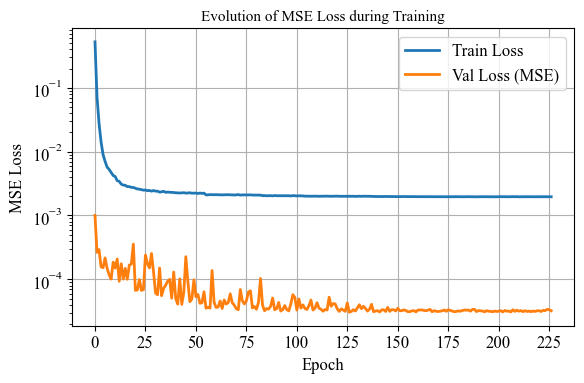

In [23]:
# === Configuración global ===
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["text.usetex"] = False  #  pon True solo si MiKTeX funciona
plt.rcParams["axes.titlesize"] = 11

# === GRAFICAR MSE ===

# Crear carpeta para guardar imagen si no existe
os.makedirs("LOSS_IMG", exist_ok=True)
loss_img_filename = model_name.replace(".pth", ".svg")
loss_img_path = os.path.join("LOSS_IMG", loss_img_filename)

# Crear figura (usa figsize global)
fig, ax = plt.subplots()

ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Val Loss (MSE)', linewidth=2)

# Escala logarítmica en eje y (opcional)
ax.set_yscale("log")

# Ejes y título coherentes
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Evolution of MSE Loss during Training')
ax.legend()
ax.grid(True)

# Forzar ticks del eje X a enteros
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Ajustar espacios
plt.tight_layout()

# Guardar en formato SVG
plt.savefig(loss_img_path, format="svg")

plt.show()

### Carga de modelos ya entrenados

In [24]:
if config["load_model"]:
    from dataset_utils import load_model_by_name

    # Definir el modelo a cargar, los modelos guardados no guardan la arquitectura de la red
    model = GCN(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        output_dim=config["output_dim"],
        num_layers=config["num_layers"],
        use_dropout=config["use_dropout"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=config["use_batchnorm"],
        use_residual=config["use_residual"]
    ).to(device)

    # Nombre exacto del archivo que quieres cargar, cambiar solo los números
    model_filename = "GCN_Layers_8_HDim_32_Epochs_215_Lr_0.000004439_B_LOSS_True_Lambda_1_H_LOSS_True_Lambda_10_PI_True_Lambda_0.001_Batch_32.pth"

    # Cargar modelo concreto
    model = load_model_by_name(model, model_filename)
    print("Modelo cargado:", model_filename)


### Evaluación

Evaluando en test set con visualización de un ejemplo:


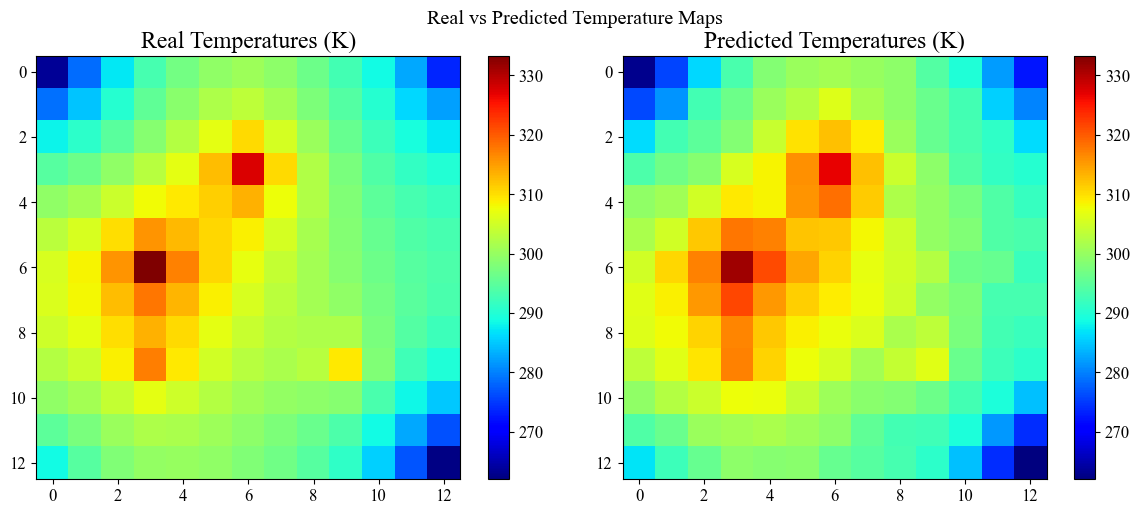

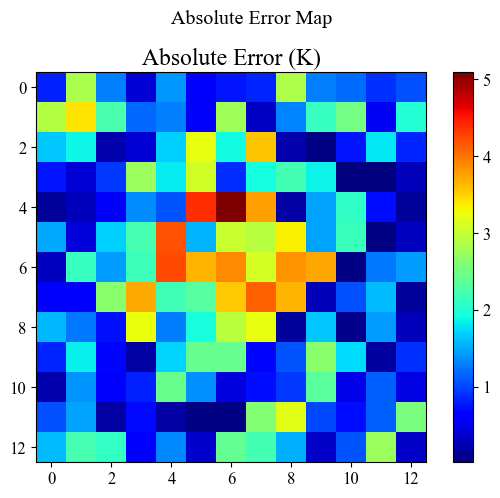

MAE en Kelvin     : 1.649 K
RMSE en Kelvin    : 2.067 K
MSE en Kelvin²    : 4.274 K²
Resultados del test:
MSE       : 0.000032
MAE       : 0.004518
R²        : 0.9696
Accuracy  : 85.82%
Boundary Loss  : 2.685718 K²
Heaters Loss  : 4.236732 K²
Physics Loss  : 1.490625 W²


In [25]:
# Evaluar en test y graficar un ejemplo
print("Evaluando en test set con visualización de un ejemplo:")
test_mse, test_mae, test_r2, test_accuracy, test_physics, test_boundary, test_heater, test_rmse, test_total_loss = evaluate(
    model, test_loader, device, norm_info, lambda_physics=config["lambda_physics"],
    use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
    use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
    use_heater_loss=config["use_heater_loss"],
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=True
)

physics_loss_str = f"{test_physics:.6f}" if test_physics is not None else "N/A"

max_T_outputs = norm_info["max_T_outputs"].to(device)
mae_K = test_mae * max_T_outputs
rmse_K = test_rmse * (max_T_outputs)
mse_K = test_mse * (max_T_outputs ** 2)
print(f"MAE en Kelvin     : {mae_K:.3f} K")
print(f"RMSE en Kelvin    : {rmse_K:.3f} K")
print(f"MSE en Kelvin²    : {mse_K:.3f} K²")
b_loss = test_boundary * (max_T_outputs ** 2)
h_loss = test_heater * (max_T_outputs ** 2)

print("Resultados del test:")
print(f"MSE       : {test_mse:.6f}")
print(f"MAE       : {test_mae:.6f}")
print(f"R²        : {test_r2:.4f}")
print(f"Accuracy  : {test_accuracy:.2f}%")
print(f"Boundary Loss  : {b_loss:.6f} K²")
print(f"Heaters Loss  : {h_loss:.6f} K²")
print(f"Physics Loss  : {physics_loss_str} W²")

### GNNExplainer

Número de nodos: 169


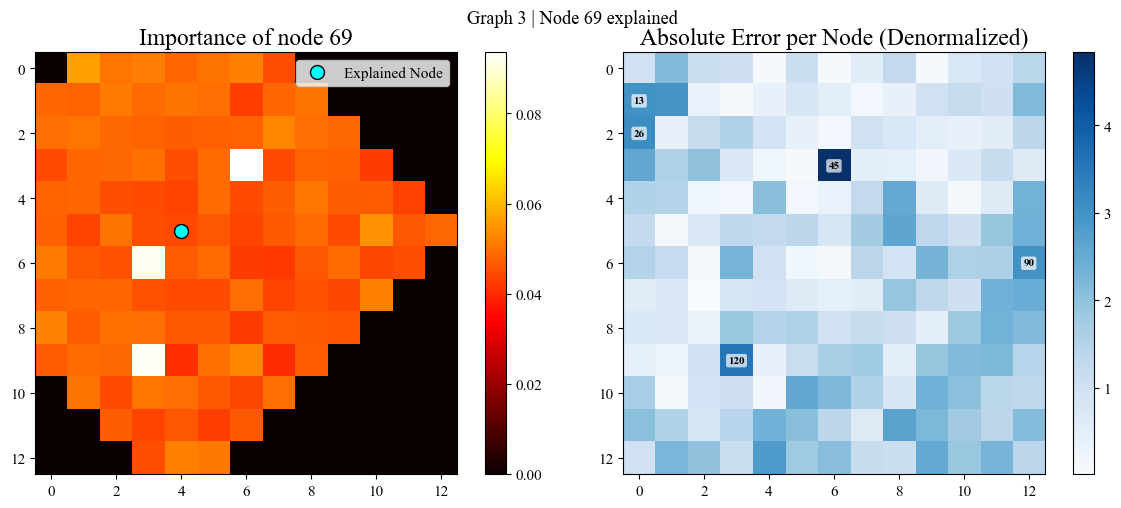

In [30]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
plt.rcParams["text.usetex"] = False  # mientras MiKTeX no esté operativo
plt.rcParams["axes.titlesize"] = 17

# Poner el modelo en modo evaluación
model.eval()

# Crear el explainer solo una vez
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    edge_mask_type='object',
    node_mask_type='attributes',
    model_config=ModelConfig(
        mode='regression',
        task_level='node',
        return_type='raw'
    )
)

# ---------------- CONFIGURACIÓN ----------------
graph_idx = 3      # <- Cambia este valor para elegir el grafo del test set
node_idx = 69     # <- Cambia este valor para elegir el nodo a explicar
# ------------------------------------------------

# Obtener el grafo y pasarlo a GPU si es necesario
graph = test_dataset[graph_idx].to(device)

# Predecir con el modelo
with torch.no_grad():
    pred = model(graph.x, graph.edge_index).squeeze()
true = graph.y.squeeze()
#error = torch.abs(pred - true)
pred_real = pred * max_T_interfaces
true_real = true * max_T_interfaces
error_real = torch.abs(pred_real - true_real)

# Obtener explicación
explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    index=node_idx
)

# Obtener importancia del explainer y agrupar por nodo
importance = explanation.node_mask.squeeze().cpu()      # Así obtenemos las features por nodo
importance = importance.view(-1, 3)                     # Cambiamos a un tensor que pueda ser interpretado como [num_nodes, num_features]
importance_per_node = importance.mean(dim=1)            # [num_nodes] Hacemos la media de la importancia de las 3 características en la predicción

# Obtener tamaño cuadrícula real del dataset
num_nodes = graph.y.numel()
print("Número de nodos:", num_nodes)
grid_size = int(num_nodes ** 0.5)
assert grid_size ** 2 == num_nodes, f"El número de nodos ({num_nodes}) no coincide con cuadrícula {grid_size}x{grid_size}"

# Convertir vectores a cuadrícula
importance_grid = importance_per_node.view(grid_size, grid_size)
error_grid = error_real.view(grid_size, grid_size).cpu()
# === Visualización coherente con formato ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Mantén tamaño ancho solo aquí

# Mapa de importancia
im1 = axs[0].imshow(importance_grid, cmap='hot')

row = node_idx // grid_size
col = node_idx % grid_size
axs[0].plot(col, row, 'o', markersize=10, markeredgecolor='black',
            markerfacecolor='cyan', label='Explained Node')
axs[0].legend(loc='upper right')

axs[0].set_title(f"Importance of node {node_idx}")
fig.colorbar(im1, ax=axs[0])

# Mapa de error absoluto
im2 = axs[1].imshow(error_grid, cmap='Blues')

top_n = 5
top_error_nodes = torch.topk(error_real, top_n).indices.cpu()
for idx in top_error_nodes:
    idx = idx.item()
    row = idx // grid_size
    col = idx % grid_size
    axs[1].text(
        col, row, str(idx),
        ha='center', va='center',
        fontsize=8, fontweight='bold',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white', edgecolor='none', alpha=0.7)
    )
axs[1].set_title("Absolute Error per Node (Denormalized)")
fig.colorbar(im2, ax=axs[1])

fig.suptitle(f"Graph {graph_idx} | Node {node_idx} explained")
fig.tight_layout()
plt.show()



### Guardado del modelo ya entrenado

In [27]:
# Crear carpeta si no existe
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
model_path = os.path.join(save_dir, model_name)
if config["save_model"]:
    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_path)

    print(f" Modelo guardado en: {model_path}")

### Predicción

In [28]:

# from train_eval import predict
# from dataset_utils import load_latest_model
# # Cargar el modelo más reciente
# model = GCN(
#     input_dim=config["input_dim"],
#     hidden_dim=config["hidden_dim"],
#     output_dim=config["output_dim"],
#     num_layers=config["num_layers"],
#     use_dropout=config["use_dropout"],
#     dropout_rate=config["dropout_rate"],
#     use_batchnorm=config["use_batchnorm"],
#     use_residual=config["use_residual"]
# )

# model = load_latest_model(model)

# # Predecir sobre test
# predicciones = predict(model, test_loader, device, norm_info)

# print("Predicciones shape:", predicciones.shape)